In [5]:
import pandas as pd
df = pd.read_csv('rain_data.csv')
df.head()
# Drop 'Latitude' and 'Longitude' columns
df.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

# Check the result
df.head()
print(df.head())

             StasName  Year  Month  Day  Rain  Tmax  Tmin  Height
0  HARTEBEESPOORT DAM  2015      1    1   2.0  29.2  17.3    1170
1  HARTEBEESPOORT DAM  2015      1   22   0.6  34.6  17.4    1170
2  HARTEBEESPOORT DAM  2015      1   23   0.2  33.6  16.1    1170
3  HARTEBEESPOORT DAM  2015      1   24   0.0  34.3  19.4    1170
4  HARTEBEESPOORT DAM  2015      1   25   0.6  36.3  19.0    1170


In [7]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

df.head()

,StasName,Rain,Tmax,Tmin,Height,Date
0,HARTEBEESPOORT DAM,2.0,29.2,17.3,1170,2015-01-01
1,HARTEBEESPOORT DAM,0.6,34.6,17.4,1170,2015-01-22
2,HARTEBEESPOORT DAM,0.2,33.6,16.1,1170,2015-01-23
3,HARTEBEESPOORT DAM,0.0,34.3,19.4,1170,2015-01-24
4,HARTEBEESPOORT DAM,0.6,36.3,19.0,1170,2015-01-25


In [11]:
import numpy as np

# Small epsilon to avoid division by zero
EPSILON = 1e-6

# Accumulated rainfall over the past 7 days
df['Rain7D'] = df['Rain'].rolling(window=7, min_periods=1).sum()

# Normalize rain with epsilon
rain_max = df['Rain7D'].max()
df['RainScore'] = df['Rain7D'] / (rain_max + EPSILON)

# Normalize Tmin (ideal: >15°C)
df['TminScore'] = df['Tmin'].apply(lambda x: max(0, min((x - 15) / 10, 1)))

# Tmax score peaks around 32°C
df['TmaxScore'] = df['Tmax'].apply(lambda x: max(0, 1 - abs(x - 32) / 10))

# Height normalization (lower = more growth)
height_min = df['Height'].min()
height_range = df['Height'].max() - height_min + EPSILON
df['HeightScore'] = 1 - ((df['Height'] - height_min) / height_range)

# Simulated growth (rain-focused weights)
df['HyacinthGrowth'] = (
    0.6 * df['RainScore'] +
    0.15 * df['TminScore'] +
    0.15 * df['TmaxScore'] +
    0.10 * df['HeightScore']
)

# Clamp to [0,1]
df['HyacinthGrowth'] = df['HyacinthGrowth'].clip(0, 1)

# Show results
df[['Date', 'Rain', 'Rain7D', 'Tmin', 'Tmax', 'Height', 'HyacinthGrowth']].tail()



,Date,Rain,Rain7D,Tmin,Tmax,Height,HyacinthGrowth
2168,2021-05-02,0.2,24.0,6.6,19.7,1170,0.167797
2169,2021-05-03,0.0,24.0,4.4,21.6,1170,0.167797
2170,2021-05-09,0.0,24.0,4.0,20.7,1170,0.167797
2171,2021-05-19,0.0,24.0,1.9,20.9,1170,0.167797
2172,2021-05-22,0.0,5.4,2.1,19.4,1170,0.115254


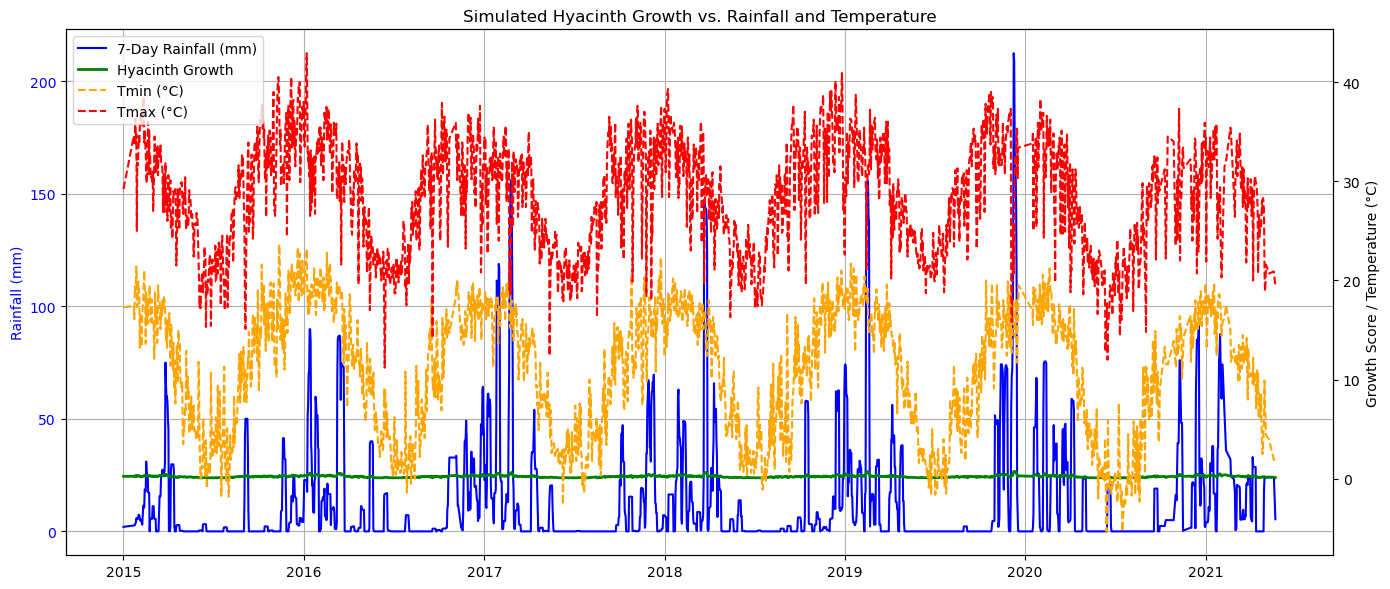

In [13]:
import matplotlib.pyplot as plt

# Make sure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Rainfall
ax1.plot(df['Date'], df['Rain7D'], label='7-Day Rainfall (mm)', color='blue')
ax1.set_ylabel('Rainfall (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for growth and temperature
ax2 = ax1.twinx()

# Plot Hyacinth Growth
ax2.plot(df['Date'], df['HyacinthGrowth'], label='Hyacinth Growth', color='green', linewidth=2)

# Plot Tmin and Tmax
ax2.plot(df['Date'], df['Tmin'], label='Tmin (°C)', color='orange', linestyle='dashed')
ax2.plot(df['Date'], df['Tmax'], label='Tmax (°C)', color='red', linestyle='dashed')

ax2.set_ylabel('Growth Score / Temperature (°C)')
ax2.tick_params(axis='y')

# Title and grid
plt.title('Simulated Hyacinth Growth vs. Rainfall and Temperature')
ax1.grid(True)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


In [15]:
#training the ML prediction model:
# Features the model will use
features = ['Rain7D', 'Tmin', 'Tmax', 'Height']
X = df[features]

# Target the model should predict
y = df['HyacinthGrowth']


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [22]:
y_pred = model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.0037
R² Score: 0.9944


In [30]:
#test for overfitting
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive values (since they are negative by default for error metrics)
cv_scores = -cv_scores

print(f"Cross-Validation MAE: {cv_scores}")
print(f"Mean CV MAE: {cv_scores.mean():.4f}")


Cross-Validation MAE: [0.00624858 0.00404116 0.00297879 0.00509375 0.00686264]
Mean CV MAE: 0.0050
